
# Image Style Transfer


**Author**: 王子杰 & 巫恩兴
 
**School**: Ocean University of China

**Class**: Computer Vision

## Background

在神经网络成为主流之前，要实现风格迁移，有一个共同的思路：首先分析一类风格的图像，然后对该类图像建立数学统计模型，最后修改输入图像使得它更符合这个统计模型。但这类方法有个缺点，即只能将特定风格场景的图片迁移到特定风格场景，因此传统方法十分受限，难以得到广泛应用。
我们选择使用Leon A. Gatys等人在2015年提出的Neural-Transfer算法。

## Introduction

该算法接收三张图片：原始图片(Input Images)，内容图片(Content Images)，风格图片(Style Images)，输出图片与Content Images内容主体相同，但又有Style Images的风格。

算法定义了两个损失：用于衡量当前图片X与Content Images在内容上的差距--内容损失Dc、与Style Images在风格上的损失Ds。通过调整X使得两个损失的加权平均值最小，经过若干次梯度下降后最终X就是算法输出。因此算法的核心在于如何计算两个损失，即如何量化两张图片的“Content”和“Style”

项目中使用VGG19这一CNN模型来提取图片语义信息，其拥有多层结构，其中每一层都用上一层的输出来提取更多特征，因此模型中的每一个卷积层都可以看做是很多个局部特征提取器。使用VGG19中的conv1_1,conv2_1,conv3_1,conv4_1,conv5_1的特征图重构图片，发现前三层图片在形状、颜色、细节上与原图差异不大；而深层网络的图片丢失了底层features，但保留了高层的语义信息。

利用这一特征我们可以把“浅层”网络的结果作为Content，而把“深层”网络的结果作为Style，最终合成Output Images，实现风格迁移。

其中内容损失计算，对于某张图片X，将其输入VGG19后，假设卷积层L有$N_L$个卷积核，特征图大小为$M_L$，其中$M_L$为特征图被“压扁”成向量以后的大小，也就是宽度×高度，且假设压扁后的特征图为$F_XL$，所以$F_XL\in{R^{N_L×M_L}}$,同理内容图在该层“压扁”特征图为$F_CL\in{R^{N_L×M_L}}$。

在计算风格损失时，由于其只保留了高层语义，并不能很好表示风格，在此引入Gram矩阵，即特征图与其转置后的矩阵做乘法得到的矩阵。

由于对每一个卷积层都可以计算内容损失和风格损失，所以可以将损失加权求得总的内容损失和风格损失，即$$L_{content}(X,C) = \sum{w_{L}L_{content}(X,C,L)}$$ $$L_{style}(X,S) = \sum{w_{L}L_{style}(X,S,L)}$$，整个网络的损失可以对其进行加权求和，所以总损失为$$L_{total}(X,D,S) = \alpha×L_{content}(X,C)+\beta×L_{style}(X,S)$$



## 算法涉及公式

**内容损失公式：**

$$L_{content}(\hat{y}, y, l) = \frac{1}{2}\sum_{i,j}(F_{ij}^{l} - P_{ij}^{l})^2$$

其中，$L_{content}$是内容损失，$\hat{y}$是生成的图像，$y$是目标图像，$F^{l}$是$\hat{y}$和$y$在第$l$层特征图的特征值，$P^{l}$是$y$在第$l$层特征图的特征值。

**Gram矩阵公式：**

$$G_{ij}^l=\frac{1}{C_{l}H_{l}W_{l}}\sum_{k=1}^{C_{l}}f_{ik}^{l}f_{jk}^{l}$$

其中，$G_{ij}^l$是第$l$层的Gram矩阵中第$i$行$j$列的元素，$C_{l}$是第$l$层的通道数，$H_{l}$和$W_{l}$分别是第$l$层特征图的高度和宽度，$f_{ik}^{l}$和$f_{jk}^{l}$分别是第$l$层特征图中第$k$个通道的第$i$个位置和第$j$个位置的特征值。

**风格损失公式：**

$$L_{style}(\hat{y}, y) = \sum_{l=1}^{L}\omega_l\frac{1}{4N_l^2M_l^2}\sum_{i,j}(G_{ij}^{l} - A_{ij}^{l})^2$$

其中，$L_{style}$是风格损失，$\hat{y}$是生成的图像，$y$是目标图像，$L$是特征图的层数，$\omega_l$是第$l$层特征图的权重，$N_l$和$M_l$分别是第$l$层特征图的通道数和特征图尺寸，$G^{l}$是$\hat{y}$在第$l$层特征图的Gram矩阵，$A^{l}$是$y$在第$l$层特征图的Gram矩阵。

## 原理

这个方法的原理很简单：我们定义两个损失，一个用于内容 ($D_C$)，一个用于风格 ($D_S$)。
$D_C$ 用于衡量两张图像在内容方面的差异，而 $D_S$ 用于衡量两张图像在风格方面的差异。
然后选取第三张图像——输入图像，并将其转换为既最小化其与内容图像之间的内容损失，又最小化其与风格图像之间的风格损失。

## 导入第三方库和选择设备(cpu or gpu)

以下是实现神经风格转移所需的第三方库列表：

torch、torch.nn、numpy（PyTorch神经网络的必要包）
torch.optim（有效的梯度下降算法）
PIL、PIL.Image、matplotlib.pyplot（加载和显示图像）
torchvision.transforms（将PIL图像转换为张量）
torchvision.models（训练或加载预训练模型）
copy（用于深度复制模型的系统包）



In [134]:
from __future__ import print_function

import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils
from PIL import Image

接下来，我们需要选择在哪个设备上运行神经网络，并导入内容和样式图像。
对于图像任务，在GPU上训练可以大幅提升运算速度。
使用``torc.cuda.is_available（）``检测是否有可用的GPU。
接下来，我们设置``torch.device()``，让神经网络在GPU上运算。

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 加载训练图片

导入Content Image与Style Image，原始PIL图像介于[0,255]之间，需要将其转化为[0,1]之间的Tensor格式，可以加快在GPU上的训练速度。
其次要注意图片需要有相同的大小以及通道数，这一点在实验过程中体现为png图片带有alpha通道，即四通道图片，将其与三通道jpg格式训练时报错。
因此导入图片前需要把图片在"画图"功能打开，另存为jpeg格式，去掉透明层信息，即alpha通道，再进行训练。


In [136]:
# 当使用多张内容图进行批量迁移时辅助函数
def get_files_relative_path(basic_path):
    """
    返回文件夹路径内所有文件的相对路径列表
    """
    file_list = []
    for file in os.listdir(basic_path):
        file_list.append(basic_path + file)
    return file_list

In [137]:
imsize = 512 if torch.cuda.is_available() else 128  # 如果没有GPU则使用128，否则512

loader = transforms.Compose([
    transforms.Resize(imsize),  # 最小边缩放，并非imsize × imsize
    transforms.ToTensor()])  # 转化为Tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # 打包成batch（实际上只有一张图片），以符合神经网络的输入维度
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/orange/steampunk.jpg")
content_img = image_loader("./images/blue/cyberpunk.jpg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"


下面为显示图片的函数``imshow()``，由于StyleImage与ContentImage都是Tensor格式，
需要将其转化为PIL格式才能使用PLT库显示。
可视化可以辅助确认加载的图像是正确的


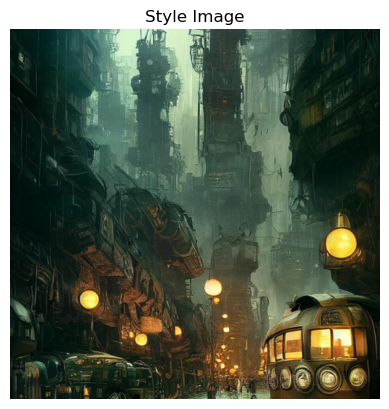

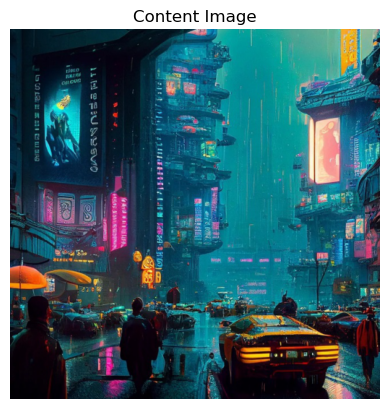

In [138]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

## Loss Functions
Content Loss

内容损失用来表示输出图像与内容图在“内容”上的损失。
由于需要在VGG的很多个卷积层上都计算内容损失，因此这里将内容损失定义为一个网络模块。
该层将VGG中第L个卷积层输出的特征图$F_{XL}$作为输入，计算内容图$C$与模型输入$X$在第$L$个卷积层的内容损失为$L_{content}(X,C)$。
其中$F_{CL}$是内容图在该层的特征图，是需要提前知道的，下述代码将其传入构造函数，且使用detach函数将其变为常量。
损失值的计算为均方误差，也可使用nn.MSELoss来计算。


In [139]:
class ContentLoss(nn.Module):

    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
        # target为内容图特征F_C
        # detach将target从计算图中摘下来，防止计算梯度
        # 因为target在本Module内是一个常量，而不是变量，因此不需要计算梯度
        # 如果不调用detach，那么在梯度下降计算损失值时会跑出错误
        self.target = target.detach()

    def forward(self, input):
        # input为训练/预测图特征F_X
        self.loss = F.mse_loss(input, self.target)
        return input


上述代码并不是定义了一个严格意义上的“损失函数”，而只是一个网络模块。如果定义为损失函数还需要实现反向传播backward函数。
将ContentLoss直接加在卷积层的后面，用于计算内容损失。那么在正向传播时，可以自动计算图片与内容图在该层的内容损失值。
由于Torch自动求导机制，它的梯度也会被自动计算出来(后续代码会把self.loss加起来作为损失函数)。
为了让ContentLoss层不影响VGG19的正常运行，需要将模块设计为透明的，所有forward函数返回该层的输入。
计算出来的损失值被放到了loss中，将该模块加入VGG19后，对所有的ContentLoss层的Loss加权求和，即可得到总的内容损失值。



### Style Loss

风格损失模块与内容损失模块类似，需要放到VGG中也是透明的。为了计算风格损失，需要先计算Gram矩阵，它可以在一定程度上量化图片的风格。
下述代码即计算Gram矩阵



In [140]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b为通道数
    # (c,d)为特征图大小 (N=c*d)

    features = input.view(a * b, c * d)  # 将 F_XL 重新排列成 \hatF_XL

    G = torch.mm(features, features.t())  # 计算Gram矩阵

    # 将Gram举证除以元素总数，达到归一化目的
    return G.div(a * b * c * d)


将风格使用Gram量化后，就可以类比内容图计算风格图与输出图像的Gram矩阵的均方误差


In [141]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 导入预训练模型VGG19

使用torchvision即可快速导入VGG19预训练模型

此处导入的模型有两个``nn.Sequential`` 子模块： ``features`` 和 ``classifier``
其中``features``包含卷积层和池化层，``classifier``包含全连接层。
因为只在卷积层后面插入损失模块，且有些层在训练和评估模式的行为是不一样的，所以把``features``子模块切换到评估模式。


In [142]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

E:\ANACONDA3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\ANACONDA3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



另外，VGG在预训练时，对每个通道进行了归一化处理，因此在把图像送入VGG时也需要做相同的处理
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].


In [143]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# 创建一个模块来规范化输入图像
# 便于将其送入nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # 图像tensor的shape为[B x C x H x W].
        # B是batchSize，C是通道数，H是高度，W是宽度
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # 归一化图
        return (img - self.mean) / self.std


VGG模块的``features``包含卷积层和池化层，具体来说即Conv2d，ReLU，MaxPool2d，Conv2d，ReLU···这样的顺序。
为了将损失模块ContentLoss和StyleLoss插入其中，需要重构一个新的nn.Sequential模块，代码如下：


In [144]:
# 添加内容损失、风格损失的卷积层
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 归一化
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 用于记录已插入的损失模块
    content_losses = []
    style_losses = []

    # 假设参数cnn是nn.Sequential，给予cnn来创建一个新的nn.Sequential
    # 按顺序遍历cnn的层，在需要插入损失模块的层后面插入损失函数即可
    model = nn.Sequential(normalization)

    i = 0  # 记录经过卷积层的数量
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # 不使用inplace
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # 添加内容损失
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # 添加风格损失
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 删除没有损失模块的部分
    # 优化图像X
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


随机生成一个图片X查看，也可直接使用Content Image


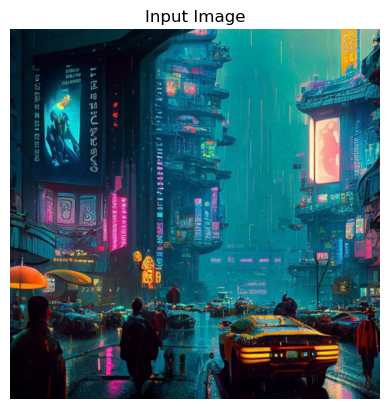

In [145]:
input_img = content_img.clone()
imshow(input_img, title='Input Image')

## 使用L-BFGS进行梯度下降

最后需要使用一个优化器来进行梯度下降，对应该模型，Gatys做了大量实验得出L-BFGS优化器效果最佳。
该优化方法收敛速度快且内存开销小


In [146]:
def get_input_optimizer(input_img):
    # 设置对图片求导
    optimizer = optim.LBFGS([input_img])
    return optimizer


然后定义一个函数来进行风格迁移。
在每次迭代过程中，将当前图片传入网络，计算得到新的内容损失和风格损失。
在损失值上调用backward函数来计算图片的梯度。
优化器需要一个"closure"函数，用于重新评估得分和返回损失值。


In [147]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """ 运行风格迁移 """
    print('构建风格迁移模型..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std, style_img,
                                                                     content_img)

    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('梯度下降..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 更正更新后图片值为0-1
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 最后一次更新
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


## 训练自己的风格


构建风格迁移模型..
梯度下降..


C:\Users\95202\AppData\Local\Temp\ipykernel_15344\1123449856.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\95202\AppData\Local\Temp\ipykernel_15344\1123449856.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 12.400578 Content Loss: 15.720591

run [100]:
Style Loss : 4.352900 Content Loss: 10.233685

run [150]:
Style Loss : 2.087754 Content Loss: 8.401981

run [200]:
Style Loss : 1.374458 Content Loss: 7.490102

run [250]:
Style Loss : 1.031275 Content Loss: 7.043716

run [300]:
Style Loss : 0.834144 Content Loss: 6.813716



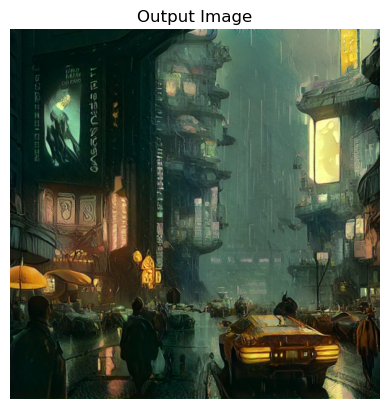

In [148]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

imshow(output, title='Output Image')

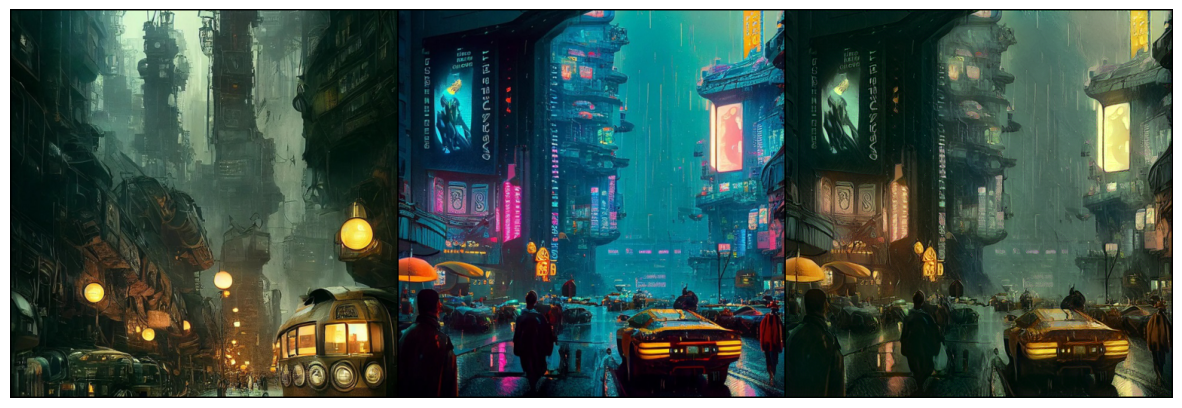

In [149]:
# 将三个张量沿第一个维度拼接
merged=torch.cat([style_img,content_img,output],dim=0)
# 将拼接好的张量转换为网格
grid = torchvision.utils.make_grid(merged,nrow=3)
# 将网格转换为numpy数组
grid = grid.permute(1,2,0).cpu().numpy()
# 显示图片
plt.figure(figsize=(15,20),frameon=False)
plt.imshow(grid)
plt.axis('off')
plt.show()

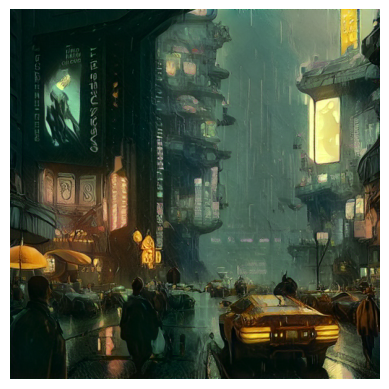

In [150]:
def saveOutcome(outcome):
    outcome = outcome.squeeze(0)
    outcome = transforms.ToPILImage()(outcome.cpu())
    outcome.save("./images/output.jpg")
    plt.figure(frameon=False)
    plt.axis('off')
    plt.imshow(outcome)
    plt.show()

saveOutcome(output)

## 封装好的函数

In [151]:
def imgStyleTransfer(content_image_path,style_image_path):
    style_img = image_loader(style_image_path)
    content_img = image_loader(content_image_path)
    output_image = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    saveOutcome(output)
#imgStyleTransfer("./images/blue/cyberpunk.jpg","./images/blue/blue1.jpg")


## Zero-Shot Noise2Noise: Efficient Image Denoising without any Data

## 浅层简单网络高效率零样本去噪


## BackGround

最近，自监督神经网络显示出出色的图像去噪性能。然而，当前的无数据集方法要么计算量大，需要噪声模型，要么图像质量不足。

在这项工作中，我们展示了一个简单的 2 层网络，无需任何训练数据或噪声分布知识，就可以以较低的计算成本实现高质量的图像去噪。

我们的方法受到 Noise2Noise 和 Neighbor2Neighbor 的启发，并且适用于逐像素独立噪声的去噪。

我们对人工、真实世界相机和显微镜噪声的实验表明，我们称为 ZS-N2N（零散粒噪声2噪声）的方法通常以更低的成本优于现有的无数据集方法，使其适用于数据可用性稀缺且受限的用例计算资源。


In [152]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import requests
from io import BytesIO
from PIL import Image

import torchvision.transforms as transforms
loader = transforms.Compose([transforms.ToTensor()])  # 转化为Tensor

device = 'cuda'

In [153]:
image = Image.open("./images/output/outcome.jpg")
clean_img = loader(image).unsqueeze(0)

#### 添加噪声

由于使用原本图片去噪效果不明显，所以我们在原本图片上添加噪声，然后再去噪。以体现出去噪的效果。

In [154]:
noise_type = 'gauss' # Either 'gauss' or 'poiss'
noise_level = 25     # Pixel range is 0-255 for Gaussian, and 0-1 for Poission

# 添加噪声
def add_noise(x,noise_level):
    # 高斯类型噪声
    if noise_type == 'gauss':
        noisy = x + torch.normal(0, noise_level/255, x.shape)
        noisy = torch.clamp(noisy,0,1)
    # 泊松类型噪声
    elif noise_type == 'poiss':
        noisy = torch.poisson(noise_level * x)/noise_level

    return noisy

noisy_img = add_noise(clean_img, noise_level)

In [155]:
# 将图片移到cuda上
clean_img = clean_img.to(device)
noisy_img = noisy_img.to(device)

In [156]:
# 定义网络
class network(nn.Module):
    def __init__(self,n_chan,chan_embed=48):
        super(network, self).__init__()
        # 激活函数为ReLU
        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        # 卷积层
        self.conv1 = nn.Conv2d(n_chan,chan_embed,3,padding=1)
        self.conv2 = nn.Conv2d(chan_embed, chan_embed, 3, padding = 1)
        self.conv3 = nn.Conv2d(chan_embed, n_chan, 1)

    # 前向传播
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.conv3(x)

        return x

n_chan = clean_img.shape[1]
model = network(n_chan)
model = model.to(device)
# 显示网络参数数量
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

The number of parameters of the network is:  22275


接下来进行图像对下采样器。它通过对非重叠补丁中的对角像素求平均值，输出两个减半空间分辨率的下采样图像，如下图所示。

它通过将图像与两个固定的卷积核 $k_1 = \begin{bmatrix}0 & 0.5 \\0.5 & 0\end{bmatrix}$ 和 $k_2 = \begin{bmatrix}0.5 & 0 \\0 & 0.5\end{bmatrix}$ 进行卷积实现，其中卷积步长为2，并分别应用于每个图像通道。


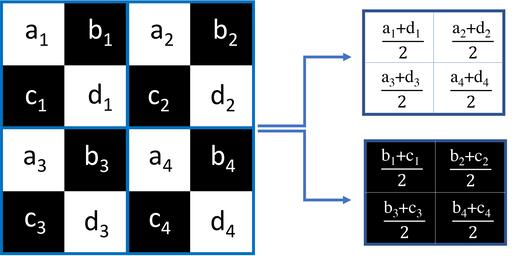

In [157]:
# 图像对下采样器
def pair_downsampler(img):
    # 获取图像的长和宽
    c = img.shape[1]

    # 两个固定的卷积核
    filter1 = torch.FloatTensor([[[[0 ,0.5],[0.5, 0]]]]).to(img.device)
    filter1 = filter1.repeat(c,1, 1, 1)

    filter2 = torch.FloatTensor([[[[0.5 ,0],[0, 0.5]]]]).to(img.device)
    filter2 = filter2.repeat(c,1, 1, 1)

    # 卷积
    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c)

    return output1, output2

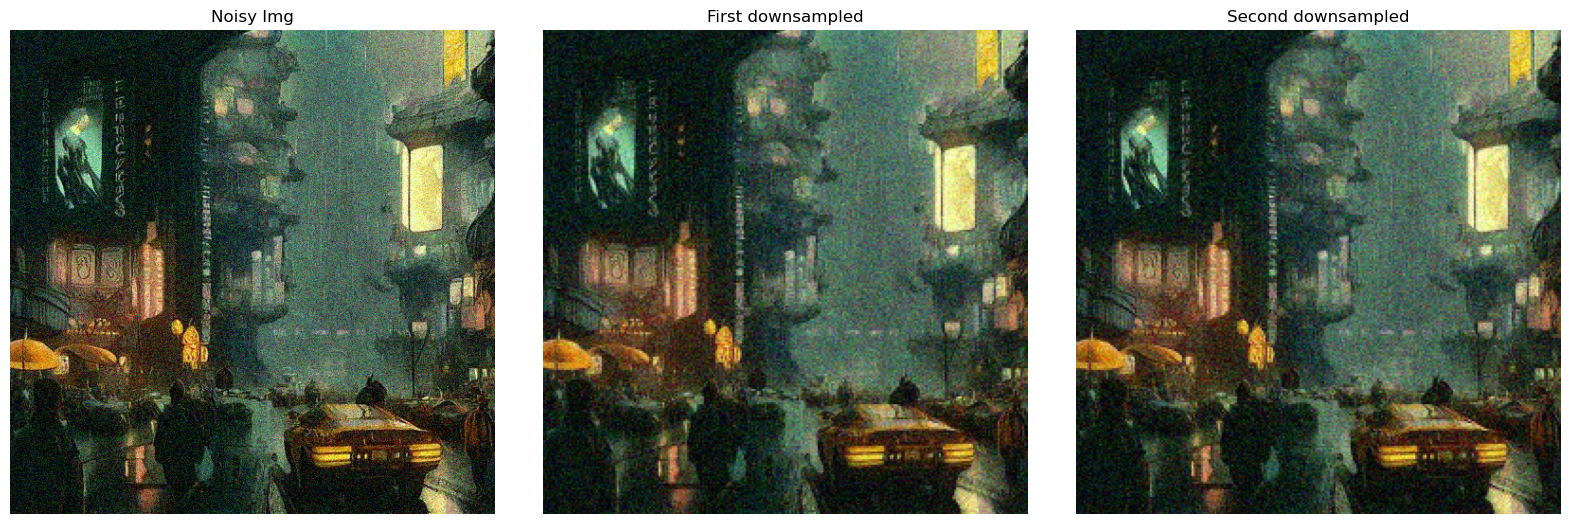

In [158]:
# 显示下采样效果
img1, img2 = pair_downsampler(noisy_img)

# 分别是原噪声图，第一次下采样，第二次下采样
img0 = noisy_img.cpu().squeeze(0).permute(1,2,0)
img1 = img1.cpu().squeeze(0).permute(1,2,0)
img2 = img2.cpu().squeeze(0).permute(1,2,0)

fig, ax = plt.subplots(1, 3,figsize=(20, 15))
fig.subplots_adjust(wspace=0.1)

ax[0].imshow(img0.detach().cpu().numpy())
ax[0].set_title('Noisy Img')
ax[0].axis('off')

ax[1].imshow(img1.detach().cpu().numpy())
ax[1].set_title('First downsampled')
ax[1].axis('off')

ax[2].imshow(img2.detach().cpu().numpy())
ax[2].set_title('Second downsampled')
ax[2].axis('off')

plt.show()

## 损失函数

这篇论文提出的新的损失函数被称为"Self-Supervised Noise2Noise (SSN2N) loss"，它鼓励网络从单个噪声图像中学习到干净图像的映射，而不需要真实的干净图像。该损失函数的主要思想是通过自监督学习的方式来进行去噪训练。

具体来说，该方法在每个训练迭代中，使用一个随机采样的噪声图像块作为输入，然后使用该块生成两个噪声图像，记为 A 和 B。这两个图像是从同一个噪声块中随机采样并进行扰动得到的。然后，网络的目标是学习将这两个噪声图像映射到它们对应的干净图像（即原始的噪声块）。为此，SSN2N损失函数定义为噪声图像 A 和 B 之间的均方误差（MSE）。

更具体地，设噪声块为 $X$，则噪声图像 $A$ 和 $B$ 可以表示为：

$$
A = X + N_A, \quad B = X + N_B
$$

其中，$N_A$ 和 $N_B$ 是两个独立的噪声扰动。然后，网络的目标就是最小化 $A$ 和 $B$ 之间的均方误差：

$$
\mathcal{L}_{SSN2N} = \frac{1}{2} \left\lVert f(A) - f(B) \right\rVert_2^2
$$

其中，$f(\cdot)$ 是网络的输出，表示将噪声图像映射到干净图像的函数。通过最小化 SSN2N 损失函数，网络可以学习到一个映射函数，将噪声图像映射到对应的干净图像，从而实现图像去噪。

需要注意的是，该方法的训练过程是自监督的，即网络不需要真实的干净图像作为监督信号。这使得该方法能够在没有成对训练数据的情况下进行训练和测试，并且可以在许多实际应用中进行零样本图像去噪。

如下所示：

$$\mathcal{L}_\mathrm{res.}(\theta) =\frac{1}{2}\left( \|D_1({y}) - f_{\theta}(D_1({y})) - D_2({y})\|_2^2 + \|D_2({y}) - f_{\theta}(D_2({y})) - D_1({y})\|_2^2 \right). $$

$$\mathcal{L}_\mathrm{cons.}(\theta) = \frac{1}{2} \left( \|f_{\theta}(D_1({y})) - D_1(f_{\theta}({y}))\|_2^2 + \|f_{\theta}(D_2({y})) - D_2(f_{\theta}({y}))\|_2^2 \right). $$

$$\mathcal{L}(\theta) = \mathcal{L}_\mathrm{res.}(\theta) + \mathcal{L}_\mathrm{cons.}(\theta), $$

其中 $y$ 是噪声输入图像，$D$ 是图像对下采样器，$f_\theta$ 是网络。

In [159]:
# 损失函数使用MSE
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

def loss_func(noisy_img):
    # 两个下采样图像
    noisy1, noisy2 = pair_downsampler(noisy_img)

    # 两个残差
    pred1 =  noisy1 - model(noisy1)
    pred2 =  noisy2 - model(noisy2)

    # 损失结果
    loss_res = 1/2*(mse(noisy1,pred2)+mse(noisy2,pred1))

    noisy_denoised =  noisy_img - model(noisy_img)
    denoised1, denoised2 = pair_downsampler(noisy_denoised)

    loss_cons=1/2*(mse(pred1,denoised1) + mse(pred2,denoised2))

    loss = loss_res + loss_cons

    return loss

In [160]:
# 训练与测试函数
def train(model, optimizer, noisy_img):

  loss = loss_func(noisy_img)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()

def test(model, noisy_img, clean_img):

    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img),0,1)
        MSE = mse(clean_img, pred).item()
        PSNR = 10*np.log10(1/MSE)

    return PSNR

def denoise(model, noisy_img):

    with torch.no_grad():
        pred = torch.clamp( noisy_img - model(noisy_img),0,1)

    return pred

In [161]:
# 迭代器和超参数
max_epoch = 2000     # training epochs
lr = 0.001           # learning rate
step_size = 1500     # number of epochs at which learning rate decays
gamma = 0.5          # factor by which learning rate decays

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [162]:
# 降噪
for epoch in tqdm(range(max_epoch)):
    train(model, optimizer, noisy_img)
    scheduler.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [163]:
# 图像PSNR值
PSNR = test(model, noisy_img, clean_img)
print(PSNR)

28.8369549837906


In [164]:
denoised_img = denoise(model, noisy_img)

denoised = denoised_img.cpu().squeeze(0).permute(1,2,0)
clean = clean_img.cpu().squeeze(0).permute(1,2,0)
noisy = noisy_img.cpu().squeeze(0).permute(1,2,0)

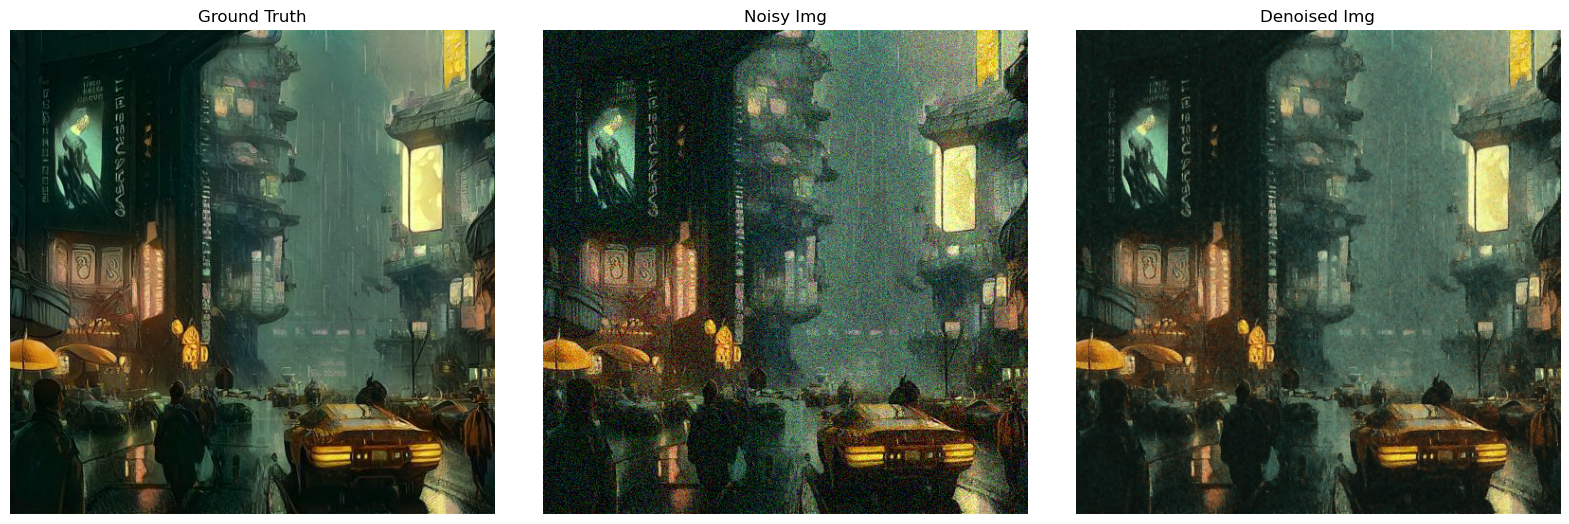

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))
fig.subplots_adjust(wspace=0.1)

ax[0].imshow(clean)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(noisy)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Noisy Img')
noisy_psnr = 10*np.log10(1/mse(noisy_img,clean_img).item())
ax[1].set(xlabel= str(round(noisy_psnr,2)) + ' dB')
ax[1].axis('off')

ax[2].imshow(denoised)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Denoised Img')
ax[2].set(xlabel= str(round(PSNR,2)) + ' dB')
ax[2].axis('off')

plt.show()